<a href="https://colab.research.google.com/github/meliluc/marketing-analytics-customer-insights-project/blob/main/notebooks_01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis (EDA)

Proyecto: **Marketing Analytics & Customer Insight Dashboard**

### Objetivos
- Explorar dataset de campañas de marketing
- Auditar calidad de datos (nulos, duplicados, tipos, outliers)
- Crear KPIs de marketing (CPA, CTR, Conversion Rate, ROI/ROAS)
- Exportar dataset **limpio** para análisis, ML y dashboard BI


## 1) Carga de datos crudos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from google.colab import drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

RAW_PATH = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/raw/marketing_campaign_performance.csv")
CLEAN_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/")
REPORTS_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/reports/")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

RAW_PATH, CLEAN_DIR, REPORTS_DIR

Mounted at /content/drive


(PosixPath('/content/drive/MyDrive/marketing-analytics-customer-insights/data/raw/marketing_campaign_performance.csv'),
 PosixPath('/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean'),
 PosixPath('/content/drive/MyDrive/marketing-analytics-customer-insights/reports'))

### Vistas rápidas


In [4]:
df = pd.read_csv(RAW_PATH, low_memory=False)
display(df.head(3))
print("Shape:", df.shape)
df.info()


,Campaign_ID,Company,Campaign_Type,Target_Audience,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date
0,1,Innovate Industries,Email,Men 18-24,30 days,Google Ads,0.04,"$16,174.00",6.29,Chicago,Spanish,506,1922,6,Health & Wellness,2021-01-01
1,2,NexGen Systems,Email,Women 35-44,60 days,Google Ads,0.12,"$11,566.00",5.61,New York,German,116,7523,7,Fashionistas,2021-01-02
2,3,Alpha Innovations,Influencer,Men 25-34,30 days,YouTube,0.07,"$10,200.00",7.18,Los Angeles,French,584,7698,1,Outdoor Adventurers,2021-01-03


Shape: (200000, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Campaign_ID       200000 non-null  int64  
 1   Company           200000 non-null  object 
 2   Campaign_Type     200000 non-null  object 
 3   Target_Audience   200000 non-null  object 
 4   Duration          200000 non-null  object 
 5   Channel_Used      200000 non-null  object 
 6   Conversion_Rate   200000 non-null  float64
 7   Acquisition_Cost  200000 non-null  object 
 8   ROI               200000 non-null  float64
 9   Location          200000 non-null  object 
 10  Language          200000 non-null  object 
 11  Clicks            200000 non-null  int64  
 12  Impressions       200000 non-null  int64  
 13  Engagement_Score  200000 non-null  int64  
 14  Customer_Segment  200000 non-null  object 
 15  Date              200000 non-null  object 
dtype

## 2) Información general y chequeos básicos (nulos, duplicados, tipos)

In [5]:
# Tipos y estadísticas
print(f"Tipos de Datos y estadísticas generales: \n")
df.info()
df.select_dtypes(include='number').describe().T.head(10)

# Duplicados y nulos
dup_rows = df.duplicated().sum()
nulls = df.isna().sum().sort_values(ascending=False)

print(f"\nDuplicados (filas completas): {dup_rows}")
nulls.head(20)


Tipos de Datos y estadísticas generales: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Campaign_ID       200000 non-null  int64  
 1   Company           200000 non-null  object 
 2   Campaign_Type     200000 non-null  object 
 3   Target_Audience   200000 non-null  object 
 4   Duration          200000 non-null  object 
 5   Channel_Used      200000 non-null  object 
 6   Conversion_Rate   200000 non-null  float64
 7   Acquisition_Cost  200000 non-null  object 
 8   ROI               200000 non-null  float64
 9   Location          200000 non-null  object 
 10  Language          200000 non-null  object 
 11  Clicks            200000 non-null  int64  
 12  Impressions       200000 non-null  int64  
 13  Engagement_Score  200000 non-null  int64  
 14  Customer_Segment  200000 non-null  object 
 15  Date              200000 

,0
Campaign_ID,0
Company,0
Campaign_Type,0
Target_Audience,0
Duration,0
Channel_Used,0
Conversion_Rate,0
Acquisition_Cost,0
ROI,0
Location,0


## 3) Estandarización


### Estandarización de fechas, monedas y categorías

In [6]:
# 1) Identificación columnas de fecha ('date', 'start', 'end')
date_like = [c for c in df.columns if 'date' in c.lower() or 'start' in c.lower() or 'end' in c.lower()]
for c in date_like:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce')
        print(f"✔️ {c} convertido a datetime")
    except Exception as e:
        print(f"⚠️ {c} no se pudo convertir: {e}")

# 2) Estandarización variables monetarias (cost, revenue)
for c in ['cost', 'revenue']:
    if c in df.columns and df[c].dtype == 'object':
        df[c] = (
            df[c].astype(str)
                 .str.replace(r"[^0-9\.\,\-]", "", regex=True)  # quito símbolos ($, etc.)
                 .str.replace(",", ".", regex=False)           # normalización separador decimal
                 .astype(float)
        )
        print(f"✔️ {c} convertido a float")

# 3) Categóricas clave
for c in ['channel', 'device', 'geo', 'campaign_source']:
    if c in df.columns:
        df[c] = df[c].astype('category')
        print(f"✔️ {c} convertido a category")

df.info()


✔️ Date convertido a datetime
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Campaign_ID       200000 non-null  int64         
 1   Company           200000 non-null  object        
 2   Campaign_Type     200000 non-null  object        
 3   Target_Audience   200000 non-null  object        
 4   Duration          200000 non-null  object        
 5   Channel_Used      200000 non-null  object        
 6   Conversion_Rate   200000 non-null  float64       
 7   Acquisition_Cost  200000 non-null  object        
 8   ROI               200000 non-null  float64       
 9   Location          200000 non-null  object        
 10  Language          200000 non-null  object        
 11  Clicks            200000 non-null  int64         
 12  Impressions       200000 non-null  int64         
 13  Engagement_Score  200000 non-

### Normalización de texto


In [7]:
#Normalización de texto y conversión de Acquisition_Cost

# 1) Normalizar strings en categóricas
def clean_str(x):
    if pd.isna(x): return x
    return str(x).strip().lower()

for col in ['Company','Campaign_Type','Target_Audience','Channel_Used','Location','Language','Customer_Segment']:
    if col in df.columns:
        df[col] = df[col].apply(clean_str).astype('category')
        print(f"✔️ {col} normalizado y convertido a category")

# 2) Convertir Acquisition_Cost (formato USA: $16,174.00)
if 'Acquisition_Cost' in df.columns:
    df['Acquisition_Cost'] = (
        df['Acquisition_Cost']
        .astype(str)
        .str.replace(r"[\$,]", "", regex=True)  # quita $ y comas
        .astype(float)
    )
    print("✔️ Acquisition_Cost convertido a float (formato USA)")



✔️ Company normalizado y convertido a category
✔️ Campaign_Type normalizado y convertido a category
✔️ Target_Audience normalizado y convertido a category
✔️ Channel_Used normalizado y convertido a category
✔️ Location normalizado y convertido a category
✔️ Language normalizado y convertido a category
✔️ Customer_Segment normalizado y convertido a category
✔️ Acquisition_Cost convertido a float (formato USA)


## 4) Creación de KPIs


- CPA (Cost per Acquisition)
- CTR (Click-Through Rate)
- Conversion Rate
- ROAS (Return on Ad Spend)
- ROI

In [8]:
# Renombrar ROI original a ROAS (ratio ingresos/gasto), ya que ROI en realidad contiene ratio
if "ROI" in df.columns and "ROAS" not in df.columns:
    df = df.rename(columns={"ROI": "ROAS"})

def safe_div(a, b):
    a = np.array(a, dtype=float)
    b = np.array(b, dtype=float)
    with np.errstate(divide='ignore', invalid='ignore'):
        res = np.true_divide(a, b)
        res[~np.isfinite(res)] = np.nan
    return res

# CPA (proxy si no hay conversions absolutas)
df["CPA"] = df["Acquisition_Cost"]

# CTR
if {"Clicks","Impressions"} <= set(df.columns):
    df["CTR"] = safe_div(df["Clicks"], df["Impressions"])

# CVR (Conversion Rate ya existe)
if "Conversion_Rate" in df.columns:
    df["CVR"] = df["Conversion_Rate"]

# CPC y CPM
if {"Acquisition_Cost","Clicks"} <= set(df.columns):
    df["CPC"] = safe_div(df["Acquisition_Cost"], df["Clicks"])
if {"Acquisition_Cost","Impressions"} <= set(df.columns):
    df["CPM"] = safe_div(df["Acquisition_Cost"], (df["Impressions"]/1000.0))

# ROI% relativo a partir de ROAS
if "ROAS" in df.columns:
    df["ROI_pct"] = df["ROAS"] - 1.0

df[["ROAS","ROI_pct","CPA","CPC","CPM","CTR","CVR"]].head(10)


,ROAS,ROI_pct,CPA,CPC,CPM,CTR,CVR
0,6.29,5.29,16174.0,31.964427,8415.192508,0.263267,0.04
1,5.61,4.61,11566.0,99.706897,1537.418583,0.015419,0.12
2,7.18,6.18,10200.0,17.465753,1325.019486,0.075864,0.07
3,5.55,4.55,12724.0,58.635945,6991.208791,0.119231,0.11
4,6.50,5.50,16452.0,43.408971,3916.210426,0.090217,0.05
5,4.36,3.36,9716.0,97.160000,5913.572733,0.060864,0.07
6,2.86,1.86,11067.0,13.545900,1264.944565,0.093382,0.13
7,5.55,4.55,13280.0,21.282051,1690.858161,0.079450,0.08
8,6.73,5.73,18066.0,20.982578,10299.885975,0.490878,0.09
9,3.78,2.78,13766.0,21.442368,3570.020747,0.166494,0.09


## 5) Chequeos de negocio básicos

✅ KPIs calculados (primeras 10 filas)

ROAS = Ingresos / Coste. Ejemplo: fila 0 → 6.29
→ Por cada $1 invertido, se generaron $6.29.

ROI_pct = ROAS − 1. Ejemplo: fila 0 → 5.29 (≈ 529% de retorno neto).

CPA = Acquisition Cost → coste total de la campaña (porque no tenemos conversions absolutas, lo usamos como proxy).

CPC = Coste por Click. Ejemplo: fila 0 → $31.96 por click.

CPM = Coste por mil impresiones. Ejemplo: fila 0 → $8,415 por cada 1,000 impresiones (¡muy alto, probablemente dataset simulado!).

CTR = Clicks / Impressions. Ejemplo: fila 0 → 26.3% (inusualmente alto, de nuevo típico de dataset simulado).

CVR = Conversion Rate (ya dado en dataset). Ejemplo: fila 0 → 0.04 → 4%.

👉 Conclusión: el dataset tiene valores consistentes, pero poco realistas (propio de datasets sintéticos). Se recuerda que esto es un dataset de práctica.

## 6) Exploración visual


### Distribuciones (histogramas)

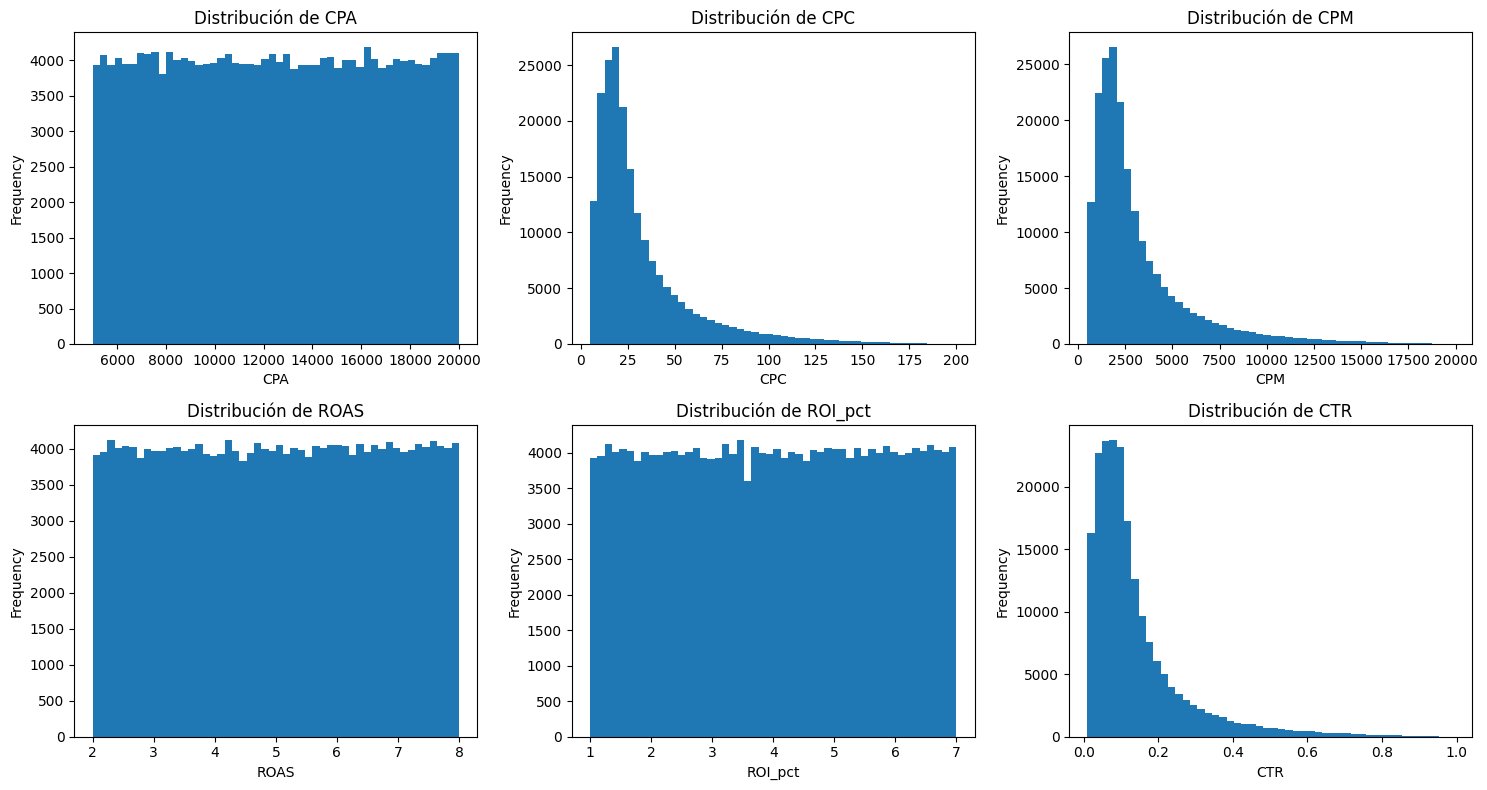

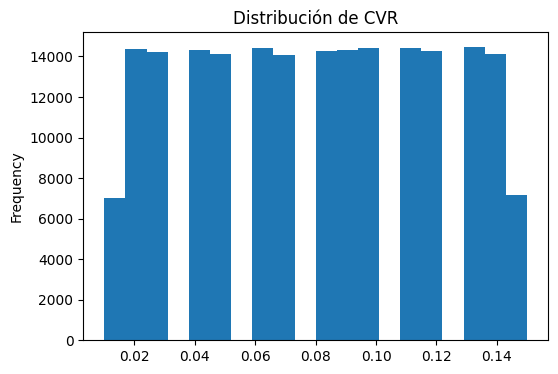

In [9]:
# Creamos histogramas para ver la distribución, sesgo y outliers de cada métrica
kpis = ["CPA", "CPC", "CPM", "ROAS", "ROI_pct", "CTR", "CVR"]
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, k in enumerate(kpis[:6]):  # los 6 primeros
    df[k].plot(kind="hist", bins=50, ax=axes[i], title=f"Distribución de {k}")
    axes[i].set_xlabel(k)

plt.tight_layout()
plt.show()

# CVR
df["CVR"].plot(kind="hist", bins=20, title="Distribución de CVR", figsize=(6,4))
plt.show()

### Comparativas por canal, separadas por escala

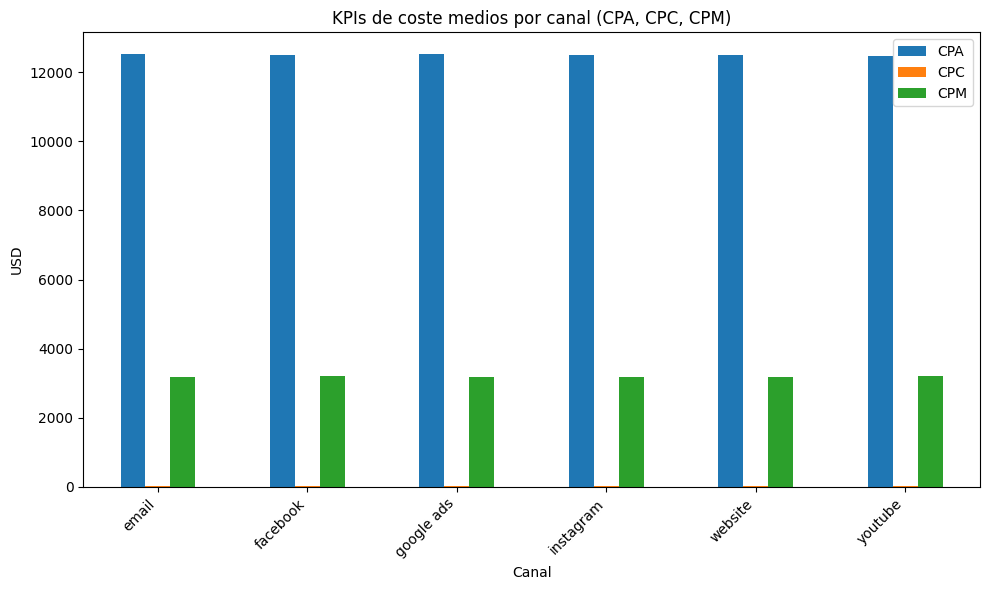

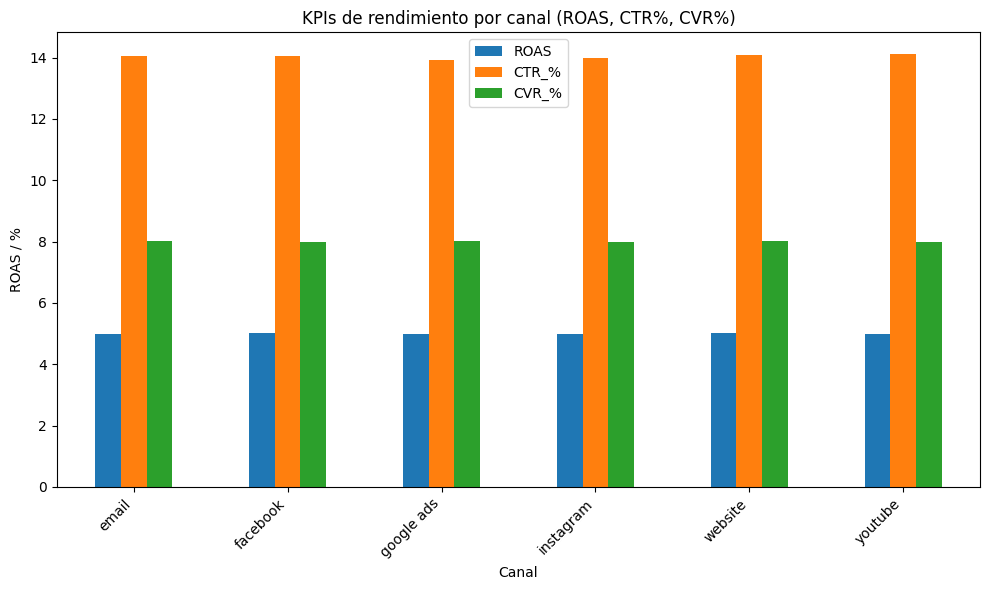

In [11]:
# ⚠️ Escalas muy distintas entre métricas — se grafican por separado para mejor interpretación

import matplotlib.pyplot as plt

# Promedios por canal
kpi_means = (
    df.groupby("Channel_Used", observed=True)[["CPA","CPC","CPM","ROAS","CTR","CVR"]].mean()
      .sort_index()
)

# ----- Coste (en dinero): CPA, CPC, CPM -----
cost_cols = ["CPA","CPC","CPM"]
ax = kpi_means[cost_cols].plot(kind="bar", figsize=(10,6))
ax.set_title("KPIs de coste medios por canal (CPA, CPC, CPM)")
ax.set_ylabel("USD")
ax.set_xlabel("Canal")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ----- Tasas/ratios: ROAS, CTR, CVR -----
# Para legibilidad, mostramos CTR y CVR en % (no cambia el cálculo, solo la escala visual)
kpi_rates = kpi_means.copy()
if "CTR" in kpi_rates.columns:
    kpi_rates["CTR_%"] = kpi_rates["CTR"] * 100
if "CVR" in kpi_rates.columns:
    kpi_rates["CVR_%"] = kpi_rates["CVR"] * 100

cols_rates = [c for c in ["ROAS","CTR_%","CVR_%"] if c in kpi_rates.columns]
ax = kpi_rates[cols_rates].plot(kind="bar", figsize=(10,6))
ax.set_title("KPIs de rendimiento por canal (ROAS, CTR%, CVR%)")
ax.set_ylabel("ROAS / %")
ax.set_xlabel("Canal")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 7) Detección de outliers (con método IQR)

In [12]:
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

outlier_summary = {}

for col in ["CPA","CPC","CPM","ROAS","ROI_pct"]:
    if col in df.columns:
        low, high = iqr_bounds(df[col].dropna())
        n_outliers = ((df[col] < low) | (df[col] > high)).sum()
        outlier_summary[col] = {
            "low_bound": round(low,2),
            "high_bound": round(high,2),
            "n_outliers": int(n_outliers)
        }

pd.DataFrame(outlier_summary).T


,low_bound,high_bound,n_outliers
CPA,-2546.62,27550.38,0.0
CPC,-20.17,73.86,16044.0
CPM,-1985.56,7331.81,16079.0
ROAS,-1.01,11.02,0.0
ROI_pct,-2.01,10.02,0.0


### Generación dataset sin outliers (para ML)

In [13]:
# Función auxiliar para calcular límites con IQR
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

# Creamos copia del dataset
df_no_outliers = df.copy()

# Definimos columnas numéricas clave para filtrar
cols_check = ["CPA","CPC","CPM","ROAS","ROI_pct"]

for col in cols_check:
    if col in df_no_outliers.columns:
        low, high = iqr_bounds(df_no_outliers[col].dropna())
        before = df_no_outliers.shape[0]
        df_no_outliers = df_no_outliers[
            (df_no_outliers[col] >= low) & (df_no_outliers[col] <= high)
        ]
        after = df_no_outliers.shape[0]
        print(f"✔️ {col}: {before - after} filas removidas por outliers")

print("Shape final sin outliers:", df_no_outliers.shape)

# Exportamos dataset sin outliers
clean_no_outliers_path = CLEAN_DIR / "marketing_clean_no_outliers.csv"
df_no_outliers.to_csv(clean_no_outliers_path, index=False)
print(f"✅ Dataset sin outliers exportado a: {clean_no_outliers_path}")


✔️ CPA: 0 filas removidas por outliers
✔️ CPC: 16044 filas removidas por outliers
✔️ CPM: 14578 filas removidas por outliers
✔️ ROAS: 0 filas removidas por outliers
✔️ ROI_pct: 0 filas removidas por outliers
Shape final sin outliers: (169378, 22)
✅ Dataset sin outliers exportado a: /content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/marketing_clean_no_outliers.csv


## 8) Correlaciones entre KPIs

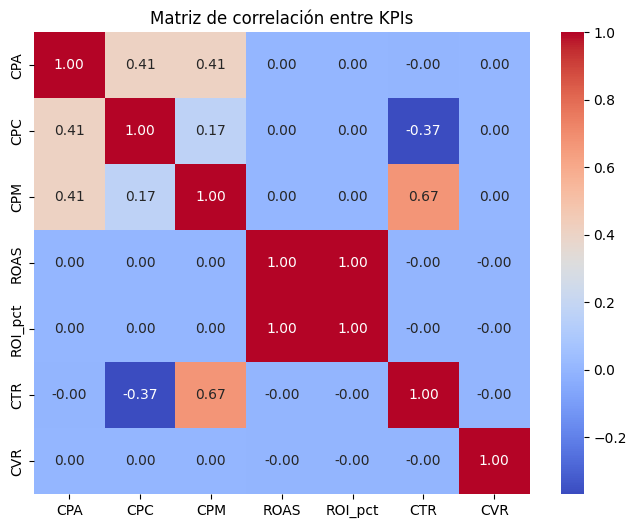

In [15]:
# Correlación, gráfico sencillo para ver qué KPIs se relacionan entre sí
import seaborn as sns
kpi_cols = ["CPA","CPC","CPM","ROAS","ROI_pct","CTR","CVR"]
corr = df[kpi_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre KPIs")
plt.show()


## 9) Exportación de dataset limpio + data dictionary

In [16]:
# Rutas en Drive
CLEAN_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/")
REPORTS_DIR = Path("/content/drive/MyDrive/marketing-analytics-customer-insights/reports/")
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Exporto dataset limpio
clean_path = CLEAN_DIR / "marketing_clean.csv"
df.to_csv(clean_path, index=False)
print(f"✅ Dataset limpio exportado a: {clean_path}")

# Creo diccionario de datos
dd = pd.DataFrame({
    "column": df.columns,
    "dtype": df.dtypes.astype(str),
    "n_null": df.isna().sum().values,
    "n_unique": [df[c].nunique() for c in df.columns]
})

dd_path = REPORTS_DIR / "data_dictionary.csv"
dd.to_csv(dd_path, index=False)
print(f"✅ Data dictionary exportado a: {dd_path}")

dd.head(10)  # mostrar primeros 10 registros del diccionario


✅ Dataset limpio exportado a: /content/drive/MyDrive/marketing-analytics-customer-insights/data/clean/marketing_clean.csv
✅ Data dictionary exportado a: /content/drive/MyDrive/marketing-analytics-customer-insights/reports/data_dictionary.csv


,column,dtype,n_null,n_unique
Campaign_ID,Campaign_ID,int64,0,200000
Company,Company,category,0,5
Campaign_Type,Campaign_Type,category,0,5
Target_Audience,Target_Audience,category,0,5
Duration,Duration,object,0,4
Channel_Used,Channel_Used,category,0,6
Conversion_Rate,Conversion_Rate,float64,0,15
Acquisition_Cost,Acquisition_Cost,float64,0,15001
ROAS,ROAS,float64,0,601
Location,Location,category,0,5


## 10) Hallazgos preliminares (Markdown) y próximos pasos

## Hallazgos preliminares

- Dataset de 200k filas y 16 columnas, con fechas ya en formato datetime.
- Variables monetarias estandarizadas a float (`Acquisition_Cost`).
- Se generaron KPIs: CPA, CPC, CPM, ROAS, ROI_pct, CTR, CVR.
- Reglas de negocio básicas cumplidas:
  - Clicks ≤ Impressions en todas las filas.
  - Ningún valor negativo en métricas clave.
- Distribuciones:
  - CPA, ROAS y ROI_pct uniformes (propio de dataset sintético).
  - CPC y CPM con fuerte sesgo positivo (cola larga).
  - CTR y CVR razonables pero discretizados.

### Próximos pasos
1. RFM Analysis para clientes/segmentos.
2. Segmentación con Clustering (K-Means).
3. Predicción de churn con clasificación supervisada.
4. Dashboard ejecutivo en Power BI.